# Introduction

This tutorial is intended to demonstrate how to craft model predictive control (MPC) strategies manually in Python using [CasADi](https://web.casadi.org/docs/). It assumes that you have a basic understanding of coding structure in Python and background on optimization and control. Resources provided below may be used to learn more. Blog posts on [CasADi's blog section](https://web.casadi.org/blog/) are also useful in using CasADi to craft optimization problems.

* [Solving Nonlinear Programs with CasADi's Opti Stack](https://web.casadi.org/blog/opti/)
* [Formulating Optimal Control Problems with CasADi's Opti Stack](https://web.casadi.org/blog/ocp/)

## Resources
MPC books 
* [Model Predictive Control - Rawlings](https://sites.engineering.ucsb.edu/~jbraw/mpc/)
* [Predictive Control for Linear and Hybrid Systems - Borrelli](https://sites.google.com/berkeley.edu/mpc-lab/mpc-course-material?pli=1)

## Other Python Tools
For developing your own MPC strategies, it is recommended to construct your own controllers using the method described in this tutorial. However, off-the-shelf tools exist to generate and simulate controllers for pre-defined problems. The following list includes some of these tools:
* [Pyomo](https://pyomo.readthedocs.io/en/stable/)
* [do-mpc](https://www.do-mpc.com/en/latest/)

### Copyright and Use
This tutorial was created by Kimberly J. Chan for the Mesbah Lab group at the University of California, Berkeley.

Created: March 30, 2023

Last Modified: April 26, 2023

(c) Mesbah Lab 2023


Note: This tutorial is intended to be run using Google Colab, but the same principles apply when running on your own machine.

In [1]:
#@title Install CasADi
!pip install casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Import Relevant Packages
import numpy as np
import matplotlib.pyplot as plt
import casadi as cas

# CasADi

[CasADi](https://web.casadi.org) is a "tool for nonlinear optimization and algorithmic differentiation."

It uses a **symbolic framework** to aid in formulating optimization problems and algorithmic differentiation. Symbols in code are used to denote a variable that the computer/solver/algorithm will determine. They do not have an intrinsic value.

In [3]:
# creating a casadi symbol
x = cas.SX.sym('x') # this will be a 1x1 "matrix", scalar
x

SX(x)

In [4]:
# creating a casadi symbol
x = cas.SX.sym('x',5) # this will be a 5x1 "matrix", vector
x

SX([x_0, x_1, x_2, x_3, x_4])

In [5]:
# creating a casadi symbol
x = cas.SX.sym('x',3,5) # this will be a 3x5 matrix
x

SX(
[[x_0, x_3, x_6, x_9, x_12], 
 [x_1, x_4, x_7, x_10, x_13], 
 [x_2, x_5, x_8, x_11, x_14]])

The use of *symbols* allows **expressions** to be easily defined in code.

In [6]:
x = cas.SX.sym('x')
y = cas.SX.sym('y')
# example of casadi expression
cas.sqrt(x+y**2) # the result is a symbolic representation of the expression (which would result in a scalar output)

SX(sqrt((x+sq(y))))

Symbolic expressions can be used as a tool to create CasADi functions. CasADi functions can then be used elsewhere. CasADi functions are similar to function definitions in Python, but since the backend of CasADi is based in C with less overhead than common matrix packages (e.g., NumPy), it can sometimes be advantageous to use CasADi to formulate functions so that other codes can run faster.

In [7]:
x = cas.SX.sym('x')
y = cas.SX.sym('y')
# example of casadi expression
out = cas.sqrt(x+y**2)
# create a casadi function
# the order of arguments is: name, [inputs to Function], [outputs of Function]
f = cas.Function('f', [x,y], [out])
# the output is a pointer or reference to the casadi function
# it can be used as a function call

a = 3.0
b = 7.5
print('f(a,b): ', f(a,b)) # this result is a "dense" matrix (DM), which is how casadi represents variables with actual value
# you can get a numpy representation of such a value by using the full function
print('f(a,b).full(): ', f(a,b).full())
print('type(f(a,b).full()): ', type(f(a,b).full()))

f(a,b):  7.6974
f(a,b).full():  [[7.69740216]]
type(f(a,b).full()):  <class 'numpy.ndarray'>


# Model Predictive Control

Model predictive control (MPC) is an optimization-based control strategy. The basis of MPC revolves around an optimal control problem (OCP). The OCP is an optimization problem that describes the objective of the control constrained on the dynamics and other constraints of the system. The decision variables of an OCP determine the optimal set of manipulated variables or control inputs to the system.

An example of an OCP is given as
$$
\begin{align}
\min_{\mathbf{u},\mathbf{x}} &~~ V(\mathbf{x},\mathbf{u}) \\
&~~ x_{k+1} = f(x_{k}, u_{k}), \\
&~~ \mathbf{x} \in \mathcal{X}, \mathbf{u} \in \mathcal{U}, \\
&~~ x_{0} = x(0), \\
&~~ \mathbf{x} = \{x_0,\ldots,x_N\}, \\
&~~ \mathbf{u} = \{u_0,\ldots,u_{N-1}\},
\end{align} 
$$
where $V(\mathbf{u},\mathbf{x})$ is the objective of the control (formulated as a cost), $u$ and $x$ represent the inputs and states of the system, respectively, $f(\cdot)$ represent the one-step-ahead prediction of the states (dynamics of the system), $\mathcal{X}$ and $\mathcal{U}$ are compact sets from which the states and inputs, respectively, are allowed, $x(0)$ is the initial state of the system, and $N$ is the horizon of the control.

The core idea of MPC is to solve some finite-time OCP at each time step. The optimal inputs obtained from the solution of this OCP are used to control the system. Typically, only the first optimal input is used. Then, feedback from the system is incorporated into the next OCP.

# CasADi Opti

The Opti stack is a set of helper functions within CasADi that make the construction of optimization problems more user-friendly.

| Optimization Problem Component/Function | Opti Helper |
|          :----:        |       :----:        |
| Decision Variable      | `opti.variable()`   |
| Parameter              | `opti.parameter()`  |
| Minimize Objective     | `opti.minimize()`   |
| Add Constraint         | `opti.subject_to()` |

# Example Problem: Double Integrator Model
A model for the discretized double integrator is as follows:
\begin{align*}
\underbrace{\begin{bmatrix}x^1(i+1) \\ x^2(i+1)\end{bmatrix}}_{x(i+1)} & = \underbrace{\begin{bmatrix}1 & 1 \\ 0 & 1 \end{bmatrix}}_A \underbrace{\begin{bmatrix}x^1(i) \\ x^2(i)\end{bmatrix}}_{x(i)} +  \underbrace{\begin{bmatrix}0.5 \\ 1 \end{bmatrix}}_B u(i) \\
y(i) & = \underbrace{\begin{bmatrix} 1 & 0 \end{bmatrix}}_C  \underbrace{\begin{bmatrix}x^1(i) \\ x^2(i)\end{bmatrix}}_{x(i)}
\end{align*}


We wish to solve:

\begin{align}
\min_{\mathbf{u},\mathbf{x}} &~~ x_N^\top Q_N x_N + \sum_{k=0}^{N-1} x_k^\top Q x_k + u_k^\top R u_k, \\
&~~ x_{k+1} = Ax_{k} + Bu_{k}, \\
&~~ y_{k} = Cx_{k}, \\
&~~ \mathbf{y} \in [-1,1], \mathbf{u} \in [-1,1], \\
&~~ x_{0} = x(0), \\
&~~ \mathbf{x} = \{x_0,\ldots,x_N\}, \\
&~~ \mathbf{u} = \{u_0,\ldots,u_{N-1}\},
\end{align} 

where $\sum_{k=0}^{N-1} x_k^\top Q x_k + u_k^\top R u_k$ is known as the stage cost (cost incurred at each stage of the prediction horizon) and $x_N^\top Q_N x_N$ is the terminal cost (cost incurred for the final state).

Helper CasADi functions can help formulate the problem in a more succint manner.


In [8]:
#@title Create CasADi function(s) for the model
nx = 2 # number of states
nu = 1 # number of inputs
ny = 1 # number of outputs
x = cas.SX.sym('x', nx)
u = cas.SX.sym('u', nu)

A = np.array([[1, 1],
              [0, 1]]) # 2x2 numpy array
B = np.array([[0.5],
              [1.0]]) # 2x1 numpy array
C = np.array([[1, 0]]) # 1x2 numpy array

xnext = A@x + B@u # the @ symbol is an overloaded function that performs matrix multiplication in Python
f = cas.Function('f', [x,u], [xnext]) # equation for the state evolution

y = C@x
h = cas.Function('h', [x], [y]) # equation for the output

In [9]:
#@title Create CasADi function(s) for the cost(s)/objective

# define weights for the cost components -- these are tunable!
Q = np.eye(nx)
R = np.eye(nu)
QN = np.eye(nx)

lstg = x.T@Q@x + u.T@R@u
stage_cost = cas.Function('stage_cost', [x,u], [lstg]) # function for the cost of each stage

lterm = x.T@QN@x
term_cost = cas.Function('term_cost', [x], [lterm]) # function for the terminal cost

We define the input and output constraints as:

\begin{align*}
|u_k| & \leq 1 \qquad \forall k = 0, 1, 2, \ldots, N-1 \\
|y_k| & \leq 1 \qquad \forall k = 0, 1, 2, \ldots, N-1
\end{align*}

In [10]:
umin = np.array([-1,-1])
umax = np.array([1,1])
ymin = np.array([-1,-1])
ymax = np.array([1,1])

# we can also set the initial values of the decision variables
u_init = np.zeros(nu)
x_init = np.zeros(nx)
y_init = np.zeros(ny)

In [11]:
#@title Use CasADi Opti to define the optimization problem
Np = 10 # prediction horizon
x0 = np.array([0.5,0])

opti = cas.Opti()

# the decision variables of the OCP include the predicted states, inputs, and
# outputs at each stage in the prediction horizon
# you can create container variables to keep track of the assignment of code variables
X = [0 for _ in range(Np+1)]
U = [0 for _ in range(Np)]
Y = [0 for _ in range(Np+1)]

# we can add the initial state as a parameter of the OCP since it is fixed
X[0] = opti.parameter(nx)
opti.set_value(X[0], x0)

# decision variable y_{0}
Y[0] = opti.variable(ny)
opti.subject_to(Y[0] == h(X[0]))

J = 0 # initialize the cost/objective

# the remaining decision variables can be added iteratively via for loop
for k in range(Np):
    # decision variable u_{k}
    U[k] = opti.variable(nu)
    opti.subject_to(opti.bounded(umin, U[k], umax))
    opti.set_initial(U[k], u_init)

    # the stage cost can be incrementally added within the for loop; this is 
    # facilitated by our stage cost function from above
    J += stage_cost(X[k], U[k])

    # decision variable x_{k+1}
    X[k+1] = opti.variable(nx)
    # opti.subject_to(opti.bounded(xmin, X[k+1], xmax)) # uncomment if there are bounds on the state
    opti.set_initial(X[k+1], x_init)

    # decision variable y_{k+1}
    Y[k+1] = opti.variable(ny)
    opti.subject_to(opti.bounded(ymin, Y[k+1], ymax))
    opti.set_initial(Y[k+1], y_init)

    # dynamics constraint
    opti.subject_to(X[k+1] == f(X[k], U[k]))
    
    # output equation constraint
    opti.subject_to(Y[k+1] == h(X[k+1]))

    # other constraints can also be added in this loop, e.g., constraints
    # restricting the magnitude of the change in input from one stage to another

# add terminal cost
J += term_cost(X[-1])

# set the cost/objective to be minimized
opti.minimize(J)

# set the options for the solver
p_opts = {'verbose': 0,
          'expand': True,
          'print_time': 1}
s_opts = {'max_iter': 1000,
          'print_level': 1,
          'tol': 1e-6}
# set the solver
opti.solver('ipopt', p_opts, s_opts)

In [12]:
#@title Solve the optimization problem
sol = opti.solve()

# you can extract the values of the decision variables after the solve has
# completed using the same references used in defining the problem
Usol = np.asarray([sol.value(u) for u in U]).reshape(nu,-1)
Xsol = np.asarray([sol.value(x) for x in X]).reshape(nx,-1)
Ysol = np.asarray([sol.value(y) for y in Y]).reshape(ny,-1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  33.00us (  5.50us)  29.12us (  4.85us)         6
       nlp_g  |  71.00us ( 11.83us)  54.87us (  9.15us)         6
  nlp_grad_f  |  39.00us (  5.57us)  35.43us (  5.06us)         7
  nlp_hess_l  |  28.00us (  5.60us)  24.12us (  4.82us)         5
   nlp_jac_g  |  32.00us (  4.57us)  32.25us (  4.61us)         7
       total  |  30.05ms ( 30.05ms)  45.85ms ( 45.85ms)         1


In [13]:
Xsol.shape

(2, 11)

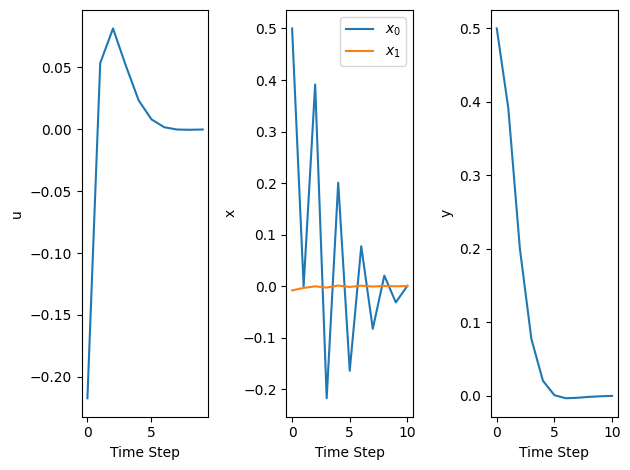

In [14]:
#@title Plot the results of the solution to the optimization problem
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
for i in range(Usol.shape[0]):
    ax1.plot(Usol[i,:], label=f'$u_{i}$')
if i>0:
    ax1.legend()
ax1.set_xlabel('Time Step')
ax1.set_ylabel('u')

for i in range(Xsol.shape[0]):
    ax2.plot(Xsol[i,:], label=f'$x_{i}$')
if i>0:
    ax2.legend()
ax2.set_xlabel('Time Step')
ax2.set_ylabel('x')

for i in range(Ysol.shape[0]):
    ax3.plot(Ysol[i,:], label=f'$y_{i}$')
if i>0:
    ax3.legend()
ax3.set_xlabel('Time Step')
ax3.set_ylabel('y')
plt.tight_layout()
plt.show()

In [15]:
#@title Run a closed-loop simulation
import time
rng = np.random.default_rng(888) # set some random number generator for noise
Nsim = 50 # simulation horizon

# container variables to store the results of each iteration of the simulation
Xsim = np.zeros((nx,Nsim+1)) # state evolution
Ysim = np.zeros((ny,Nsim+1)) # output evolution
Usim = np.zeros((nu,Nsim)) # input evolution
Jsim = np.zeros((1,Nsim)) # cost evolution
Ypredsim = np.zeros((ny,Np+1,Nsim+1)) # predicted states
csim = np.zeros((1,Nsim)) # computation time

Xsim[:,0] = np.ravel(x0) # set the initial state
Ysim[:,0] = np.ravel(h(Xsim[:,0]).full()) + rng.random(size=(ny,))/80.0
# here is a good place to reset the initial guesses of the decision variables if
# you were doing replicates, so that you have repeatability

for k in range(Nsim):
    startTime = time.time()

    # set the parameters of the optimization problem (here it is only the 
    # initial state)
    opti.set_value(X[0], Xsim[:,k])

    # solve optimization problem
    sol = opti.solve()
    # extract results
    Usol = np.asarray([sol.value(u) for u in U]).reshape(nu,-1)
    Ysol = np.asarray([sol.value(y) for y in Y]).reshape(ny,-1)
    # save results
    Usim[:,k] = Usol[:,0] # for control, we are only interested in the first optimal input
    Ypredsim[:,:,k] = Ysol # we can also save the predicted output

    # apply input to system/plant/real system
    Xsim[:,k+1] = np.ravel(f(Xsim[:,k], Usim[:,k]).full())
    # add some process noise
    Xsim[:,k+1] += rng.random(size=(nx,))/50.0 # scale down noise by 50
    Ysim[:,k+1] = np.ravel(h(Xsim[:,k+1]).full())
    # add some measurement noise
    Ysim[:,k+1] += rng.random(size=(ny,))/80.0 # scale down noise by 80

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  59.00us (  4.92us)  51.65us (  4.30us)        12
       nlp_g  | 117.00us (  9.75us)  90.52us (  7.54us)        12
    nlp_grad  |  19.00us ( 19.00us)  18.82us ( 18.82us)         1
  nlp_grad_f  |  69.00us (  4.93us)  62.53us (  4.47us)        14
  nlp_hess_l  |  43.00us (  4.30us)  39.27us (  3.93us)        10
   nlp_jac_g  |  61.00us (  4.36us)  61.31us (  4.38us)        14
       total  |  10.91ms ( 10.91ms)  11.24ms ( 11.24ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  85.00us (  4.72us)  73.89us (  4.11us)        18
       nlp_g  | 169.00us (  9.39us) 132.43us (  7.36us)        18
    nlp_grad  |  27.00us ( 13.50us)  26.17us ( 13.08us)         2
  nlp_grad_f  | 107.00us (  5.10us)  95.01us (  4.52us)        21
  nlp_hess_l  |  59.00us (  3.93us)  54.54us (  3.64us)        15
   nlp_jac_g  |  90.00us (  4.29us)  90.42us (  4.31us)        21
       tot

Plot results of simulation

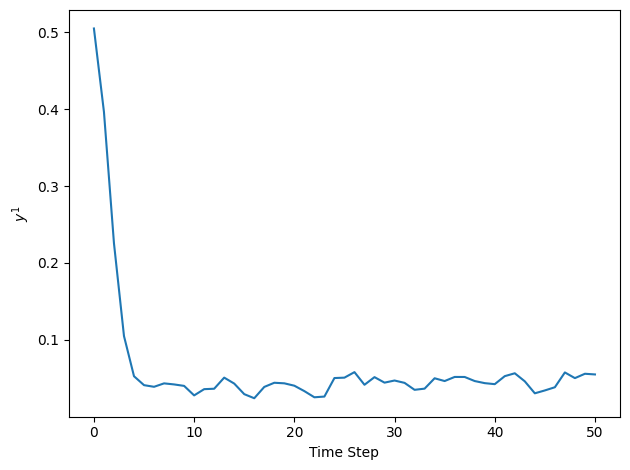

In [16]:
#@title Plot Output
fig, axes = plt.subplots(ny,1, sharex=True)
if ny > 1:
    for i in range(ny):
        axes[i].plot(Ysim[i,:])
        axes[i].set_ylabel(f'$y^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.plot(np.ravel(Ysim))
    axes.set_ylabel('$y^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.show()

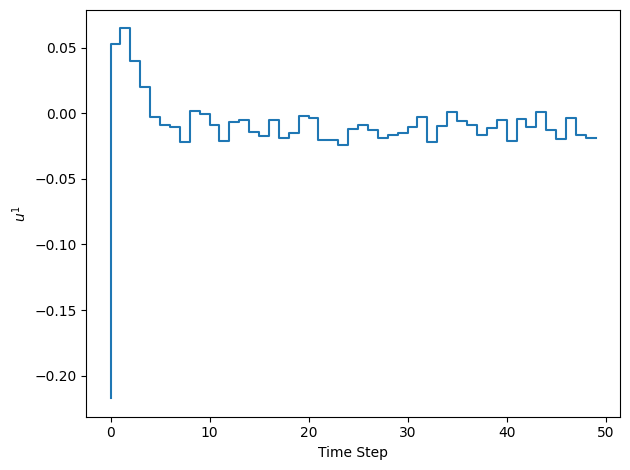

In [17]:
#@title Plot Inputs
fig, axes = plt.subplots(nu,1, sharex=True)
if nu > 1:
    for i in range(nu):
        axes[i].step(Usim[i,:])
        axes[i].set_ylabel(f'$u^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.step(np.arange(Usim.shape[1]),np.ravel(Usim))
    axes.set_ylabel('$u^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.show()

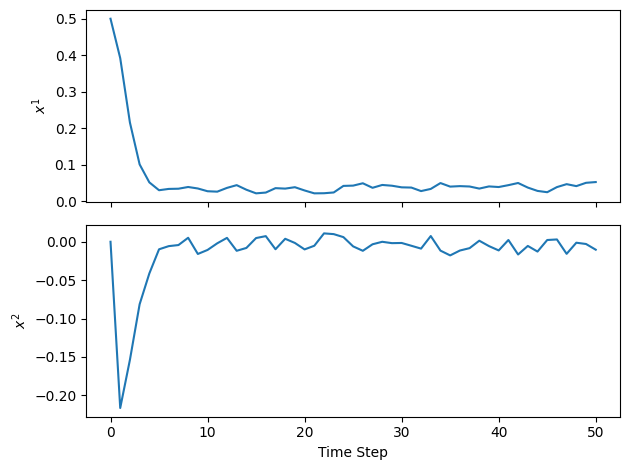

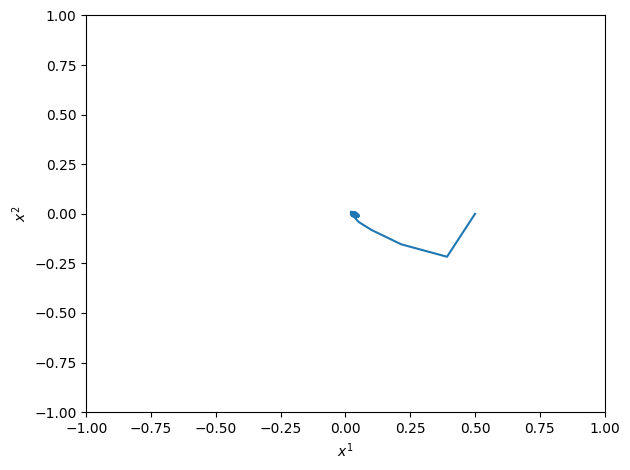

In [18]:
#@title Plot States
fig, axes = plt.subplots(nx,1, sharex=True)
if nx > 1:
    for i in range(nx):
        axes[i].plot(Xsim[i,:])
        axes[i].set_ylabel(f'$x^{i+1}$')
    axes[i].set_xlabel('Time Step')
else:
    axes.plot(np.ravel(Xsim))
    axes.set_ylabel('$x^1$')
    axes.set_xlabel('Time Step')
plt.tight_layout()
plt.draw()

fig, ax = plt.subplots(1,1)
ax.plot(Xsim[0,:], Xsim[1,:])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.tight_layout()
plt.show()